In [1]:
import rescomp as rc
import rescomp.optimizer as ro
from matplotlib import pyplot as plt

## Drag ODE, no constant
(file drag_ode1.py)

In [2]:
from sherpa import Continuous

def res_f(self, t, r, u, d):
    """ ODE to drive the reservoir node states with u(t) and a input signal d(t)"""
    beta = self.gamma + self.alpha
    transform_train = self.sigma * self.W_in @ u(t)
    transform_drive = self.delta * self.W_drive @ d(t)
    return -1 * beta * r + self.gamma*self.activ_f(self.res @ r + transform_train + transform_drive)

def res_pred_f(self, t, r, d):
    """ Reservoir prediction ode. Assumes precomputed W_out. Accepts an input signal d(t) """
    beta = self.gamma + self.alpha
    recurrence = self.sigma * self.W_in @ (self.W_out @ r)
    transform_drive =  self.delta * self.W_drive @ d(t)
    return -1* beta*r + self.gamma*self.activ_f(self.res @ r + recurrence + transform_drive)

res_odes = {
    'res_ode': res_f,
    'trained_res_ode': res_pred_f,
    'opt_parameters': [Continuous('alpha',[-5,20])]
}

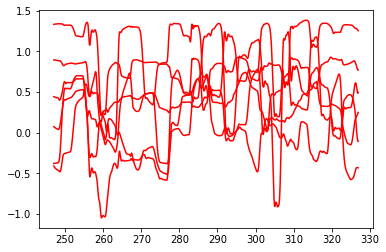

In [5]:
plt.plot(ts, Uts, 'r')
plt.show()

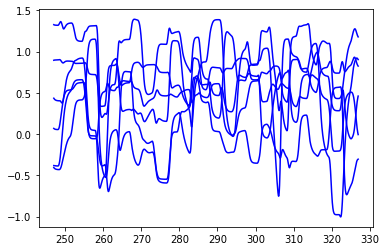

In [6]:
plt.plot(ts, pre, 'b')
plt.show()

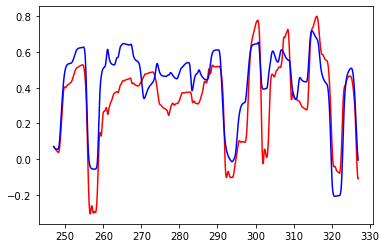

## Drag ODE, constant is hyperparameter
file: drag_ode2.py

In [ ]:
from sherpa import Continuous

def res_f(self, t, r, u, d):
    """ ODE to drive the reservoir node states with u(t) and a input signal d(t)"""
    beta = self.gamma + self.alpha
    transform_train = self.sigma * self.W_in @ u(t)
    transform_drive = self.delta * self.W_drive @ d(t)
    return -1 * beta * r + self.gamma*self.activ_f(self.res @ r + transform_train + transform_drive) + self.drt0

def res_pred_f(self, t, r, d):
    """ Reservoir prediction ode. Assumes precomputed W_out. Accepts an input signal d(t) """
    beta = self.gamma + self.alpha
    recurrence = self.sigma * self.W_in @ (self.W_out @ r)
    transform_drive =  self.delta * self.W_drive @ d(t)
    return -1* beta*r + self.gamma*self.activ_f(self.res @ r + recurrence + transform_drive) + self.drt0

res_odes = {
    'res_ode': res_f,
    'trained_res_ode': res_pred_f,
    'opt_parameters': [Continuous('alpha',[-5,20]), Continuous('drt0',[-2,2])]
}

## Drag ODE, constant is $\mathrm{Re}(\lambda v)$,
where $\lambda$ is the largest eigenvalue in magnitude of the reservoir adjacency matrix and $v$ is the corresponding eigenvector.

file: drag_ode3.py

In [ ]:
from sherpa import Continuous
from scipy.sparse.linalg import eigs
import numpy as np

def res_f(self, t, r, u, d):
    """ ODE to drive the reservoir node states with u(t) and a input signal d(t)"""
    if self.drt0 is None:
        eigval, eigvect = eigs(self.res, k=1, which='LR')
        self.drt0 = np.real(eigval * eigvect).reshape(-1)
    beta = self.gamma + self.alpha
    transform_train = self.sigma * self.W_in @ u(t)
    transform_drive = self.delta * self.W_drive @ d(t)
    return -1 * beta * r + self.gamma*self.activ_f(self.res @ r + transform_train + transform_drive) + self.drt0

def res_pred_f(self, t, r, d):
    """ Reservoir prediction ode. Assumes precomputed W_out. Accepts an input signal d(t) """
    if self.drt0 is None:
        eigval, eigvect = eigs(self.res, k=1, which='LR')
        self.drt0 = np.real(eigval * eigvect).reshape(-1)
    beta = self.gamma + self.alpha
    recurrence = self.sigma * self.W_in @ (self.W_out @ r)
    transform_drive =  self.delta * self.W_drive @ d(t)
    return -1* beta*r + self.gamma*self.activ_f(self.res @ r + recurrence + transform_drive) + self.drt0

res_odes = {
    'res_ode': res_f,
    'trained_res_ode': res_pred_f,
    'opt_parameters': [Continuous('alpha',[-5,20])],
    'parameters': {'drt0': None}
}

## Drag ODE, constant is $c\mathrm{Re}(\lambda v)$,
where $\lambda$ is the largest eigenvalue in magnitude of the reservoir adjacency matrix and $v$ is the corresponding eigenvector.
$c$ is a hyperparameter.

file: drag_ode4.py

In [11]:
from sherpa import Continuous
from scipy.sparse.linalg import eigs
import numpy as np

def res_f(self, t, r, u, d):
    """ ODE to drive the reservoir node states with u(t) and a input signal d(t)"""
    if self.drt0 is None:
        eigval, eigvect = eigs(self.res, k=1, which='LR')
        self.drt0 = np.real(eigval * eigvect).reshape(-1) * self.eigscale
    beta = self.gamma + self.alpha
    transform_train = self.sigma * self.W_in @ u(t)
    transform_drive = self.delta * self.W_drive @ d(t)
    return -1 * beta * r + self.gamma*self.activ_f(self.res @ r + transform_train + transform_drive) + self.drt0

def res_pred_f(self, t, r, d):
    """ Reservoir prediction ode. Assumes precomputed W_out. Accepts an input signal d(t) """
    if self.drt0 is None:
        eigval, eigvect = eigs(self.res, k=1, which='LR')
        self.drt0 = np.real(eigval * eigvect).reshape(-1) * self.eigscale
    beta = self.gamma + self.alpha
    recurrence = self.sigma * self.W_in @ (self.W_out @ r)
    transform_drive =  self.delta * self.W_drive @ d(t)
    return -1* beta*r + self.gamma*self.activ_f(self.res @ r + recurrence + transform_drive) + self.drt0

res_odes = {
    'res_ode': res_f,
    'trained_res_ode': res_pred_f,
    'opt_parameters': [Continuous('alpha',[-5,20]), Continuous('eigscale', [-2,2])],
    'parameters': {'drt0': None}
}

In [14]:
params = {'alpha': 7.370649981038427, 'delta': 1.3977305151604063, 'eigscale': 0.8995559583382746, 'gamma': 10.219099811415825, 'mean_degree': 2.262362369161984, 'overlap': 0.6, 'ridge_alpha': 2.0, 'sigma': 1.2966722270473288, 'spect_rad': 3.8188869419300944, 'window': 32.27484431926027}
ropt = ro.ResCompOptimizer('softrobot', 'activ_f', 'continue', 'augmented', res_ode=res_odes,add_params=[Continuous('alpha',[-20,20])], drt0=None)


In [17]:
tr, (Utr, Dtr), (ts, Dts), Uts, pre = ropt.generate_orbits(1, params)[0]


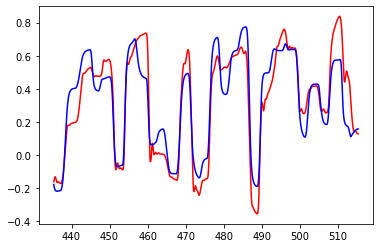

In [18]:
plt.plot(ts, Uts[:,0], 'r')
plt.plot(ts, pre[:,0], 'b')
plt.show()

## Submission script

In [ ]:
import subprocess
from datetime import datetime
from os import makedirs

EXPERIMENTS = [
    [('softrobot','activ_f','continue','augmented'), 72],
    [('softrobot','activ_f','random','augmented'), 72],
    [('softrobot','relax','continue','augmented'), 80],
    [('softrobot','relax','random','augmented'), 72]
]

for experiment, time in EXPERIMENTS:
    for odefile in ('drag_ode1','drag_ode2','drag_ode3','drag_ode4'):
        #timestamp = "{:%y%m%d%H%M%S}".format(datetime.now())
        log_dir = f"results/{odefile}/{'_'.join(experiment)}"
        try:
            makedirs(log_dir)
        except FileExistsError:
            pass
        slurm_flags=('-o', f"{log_dir}/slurm-%a.out", '-t', f"{time}:00:00", "--ntasks=16", "--nodes=1",
               "--mem-per-cpu=1G", '-J', '-'.join([odefile,*experiment]))
        subprocess.run(['sbatch', *slurm_flags, 'parallel_submit.sh', *experiment, log_dir, odefile])
        

### parallel_submit.sh

In [ ]:
#!/bin/bash

#SBATCH --mail-user=quinlan.leishman@gmail.com   # email address
#SBATCH --mail-type=END
#SBATCH --mail-type=FAIL

SYSTEM=$1
MAP_INITIAL=$2
PREDICTION_TYPE=$3
METHOD=$4
LOGDIR=$5
ODEFILE=$6

# Set the max number of threads to use for programs using OpenMP. Should be <= ppn.
export OMP_NUM_THREADS=$SLURM_CPUS_ON_NODE

profile=slurm_${SLURM_JOB_ID}_$(hostname)

#This method for using ipyparallel with slurm was taken from https://k-d-w.org/blog/2015/05/using-ipython-for-parallel-computing-on-an-mpi-cluster-using-slurm/
echo "Creating profile ${profile}"
ipython profile create ${profile}


echo "Launching controller"
~/.local/bin/ipcontroller --ip="*" --profile=${profile} --log-to-file &
sleep 10

echo "Launching engines"
srun ~/.local/bin/ipengine --profile=${profile} --location=$(hostname) --log-to-file &
sleep 30

echo "Launching job"
python3 -m rescomp.opt_then_test $SYSTEM $MAP_INITIAL $PREDICTION_TYPE $METHOD $LOGDIR --ode $ODEFILE --parallel --profile ${profile} --opt-ntrials 300 --opt-vpt-reps 32 --algorithm gpyopt
